## Exploratory Data Analysis of Grocery Sales

This is an initial exploratory analysis of the data provided for the "Corporacion Favorita" Kaggle competition. The competition can be found here: https://www.kaggle.com/c/favorita-grocery-sales-forecasting


The ultimate goal of the competition is to predict the unique product sales at the different stores of "Corporacion Favorita", a large grocery store chain in Ecuador.


A training dataset is provided that contains  information about the sales by date, product id, store as well as a promotion flag. 


The following files are also provided:
   * stores.csv: Store metadata, including city, state, type, and cluster.
   * items.csv: Item metadata, including family, class, and perishable (wrong predictions on perishable items are penalized more)
   * transacations.csv: The count of sales transactions for each date, store_nbr combination.
   * oil.csv: Daily oil price because Ecuador is an oil-dependent country.
   * holidays_events.csv: Holidays an events and information on whether those were transferred.


This analysis is still a work in progress. The main steps used are the following:
   1. Read training file, modify/add columns, summarize, visualize.
   2. Read the rest of the files, summarize, pull useful information to the training data frame.
   3. Since the end goal is to predict sales, look at how sales relate to each one of the given variables.


In this particular script I am also trying to optimize the code by (a) maximizing speed, and (b) minimizing memory usage, given also that the dataset provided is quite large (~5GB).


### Load Libraries

In [52]:
library(dplyr)
library(ggplot2) # plotting
library(data.table) # fast reading of data

library(pryr) # exploring memory usage
library(lineprof) # line profiling of code
library(microbenchmark) # comparing time of different commands
library(zoo) # used to fill in NA's with linear interpolation
library(gridExtra) # used to show plots next to each other
library(leaflet) # creating maps
library(treemapify) # creating treemaps
library(ggmap) #create maps

In [3]:
setwd(".../grocery_sales_forecasting")


### Read Training Data

This is a 4.6GB file with 125,497,040 rows and can hardly fit in memory. 
We know that years 2013 - Aug.2017 are provided so we start by looking at the last year of data.
Given that the end goal is to predict future sales the most recent year is probably the one that will be more relevant.

In [4]:
n_total = 125497040 # we know the total rows
n_read = 40000000 # rows of data to be read
n_skip = n_total - n_read

# Using fread and specifying column classes allows faster reading.
headers = fread("train.csv", nrows=1, header=FALSE, stringsAsFactors = FALSE)
train_n = fread("train.csv", nrows=n_read, skip=n_skip , colClasses=c("integer","date","integer","integer","numeric","logical"), stringsAsFactors = FALSE)
colnames(train_n) = unlist(headers)

# as.Date also becomes much faster by specifying the data format
train_n$date = as.Date(train_n$date, format="%Y-%m-%d")

summary(train_n)

Read 40000000 rows and 6 (of 6) columns from 4.654 GB file in 00:00:27


       id                 date              store_nbr        item_nbr      
 Min.   : 85497039   Min.   :2016-07-19   Min.   : 1.00   Min.   :  96995  
 1st Qu.: 95497039   1st Qu.:2016-10-31   1st Qu.:13.00   1st Qu.: 679602  
 Median :105497038   Median :2017-02-07   Median :28.00   Median :1162935  
 Mean   :105497038   Mean   :2017-02-04   Mean   :27.88   Mean   :1143926  
 3rd Qu.:115497038   3rd Qu.:2017-05-13   3rd Qu.:43.00   3rd Qu.:1473476  
 Max.   :125497038   Max.   :2017-08-15   Max.   :54.00   Max.   :2127114  
   unit_sales        onpromotion     
 Min.   :-10002.00   Mode :logical   
 1st Qu.:     2.00   FALSE:35259042  
 Median :     4.00   TRUE :4740958   
 Mean   :     8.15                   
 3rd Qu.:     8.00                   
 Max.   : 89440.00                   

We are told that negative unit sales indicate returns. Also, there are no missing values in the data.

In [5]:
# filter for the last year of data
train_n_flt = train_n %>% filter(date >= "2016-08-14" & date <= "2017-08-14") 

# with substr(), R ran out of memory. 
# as.numeric(format(...)) works but is still not efficient in terms of memory usage
train_n_flt$year = as.numeric(format(train_n_flt$date, "%Y"))
train_n_flt$month = as.numeric(format(train_n_flt$date, "%m"))
train_n_flt$day = as.numeric(format(train_n_flt$date, "%d"))

summary(train_n_flt)

       id                 date              store_nbr        item_nbr      
 Min.   : 87944113   Min.   :2016-08-14   Min.   : 1.00   Min.   :  96995  
 1st Qu.: 97306642   1st Qu.:2016-11-18   1st Qu.:13.00   1st Qu.: 679926  
 Median :106669170   Median :2017-02-18   Median :28.00   Median :1165988  
 Mean   :106669170   Mean   :2017-02-16   Mean   :27.88   Mean   :1146728  
 3rd Qu.:116031698   3rd Qu.:2017-05-18   3rd Qu.:43.00   3rd Qu.:1473483  
 Max.   :125394227   Max.   :2017-08-14   Max.   :54.00   Max.   :2127114  
   unit_sales       onpromotion           year          month       
 Min.   :-10002.0   Mode :logical    Min.   :2016   Min.   : 1.000  
 1st Qu.:     2.0   FALSE:32928300   1st Qu.:2016   1st Qu.: 4.000  
 Median :     4.0   TRUE :4521815    Median :2017   Median : 6.000  
 Mean   :     8.2                    Mean   :2017   Mean   : 6.465  
 3rd Qu.:     8.0                    3rd Qu.:2017   3rd Qu.: 9.000  
 Max.   : 89440.0                    Max.   :2017   Ma

Returns are shown as negative sales. Because we care about predicting sales we will ignore returns for now. We create an adj_sales column where 0 is assigned if sales<0.


In [6]:
train_n_flt$adj_sales = ifelse(train_n_flt$unit_sales < 0, 0 , train_n_flt$unit_sales)

# create summary data frames
# aggregate by month
train_n_month = train_n_flt %>% group_by(month) %>% summarize(tot_sales = sum(unit_sales),
                                                              tot_adj_sales = sum(adj_sales))

# aggregate by day of month
train_n_day = train_n_flt %>% group_by(day) %>% summarize(tot_sales = sum(unit_sales),
                                                        avg_sales = mean(unit_sales))

# simple time series
train_n_ts = train_n_flt %>% group_by(date) %>% summarize(tot_sales = sum(unit_sales),
                                                          tot_adj_sales = sum(adj_sales))

# aggregate by store number
train_n_store = train_n_flt %>% group_by(store_nbr) %>% summarize(tot_sales = sum(unit_sales),
                                                                        tot_adj_sales = sum(adj_sales))

# aggregate by store by month 
train_n_store_month = train_n_flt %>% group_by(month, store_nbr) %>% summarize(tot_sales = sum(unit_sales),
                                                                               tot_adj_sales = sum(adj_sales))

# aggregate by onpromotion flag
train_n_prom = train_n_flt %>% group_by(date, onpromotion) %>% summarize(avg_sales = mean(unit_sales),
                                                                         avg_adj_sales = mean(adj_sales))



Next we start creating some exploratory graphs:

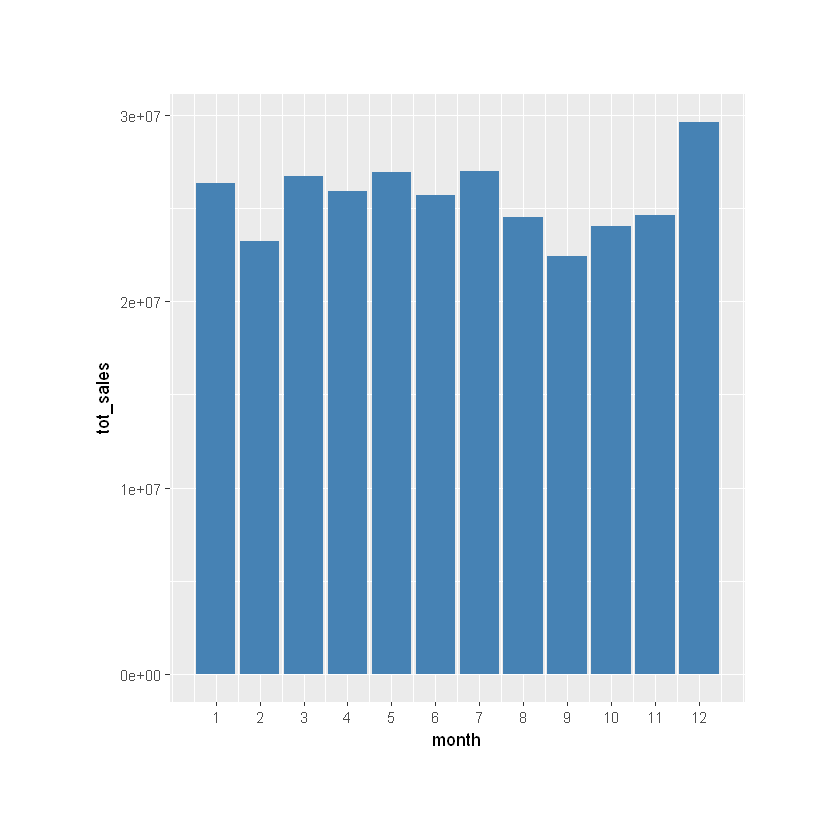

In [7]:
ggplot(train_n_month, aes(month, tot_sales)) + geom_bar(stat="identity", fill="steelblue") + 
        scale_x_continuous(breaks=1:12) + theme(plot.margin = unit(c(2, 2, 2, 2), "cm"))

Total sales are highest in December and lowest in September and February. 
Removing returns does not have any effect on the pattern.

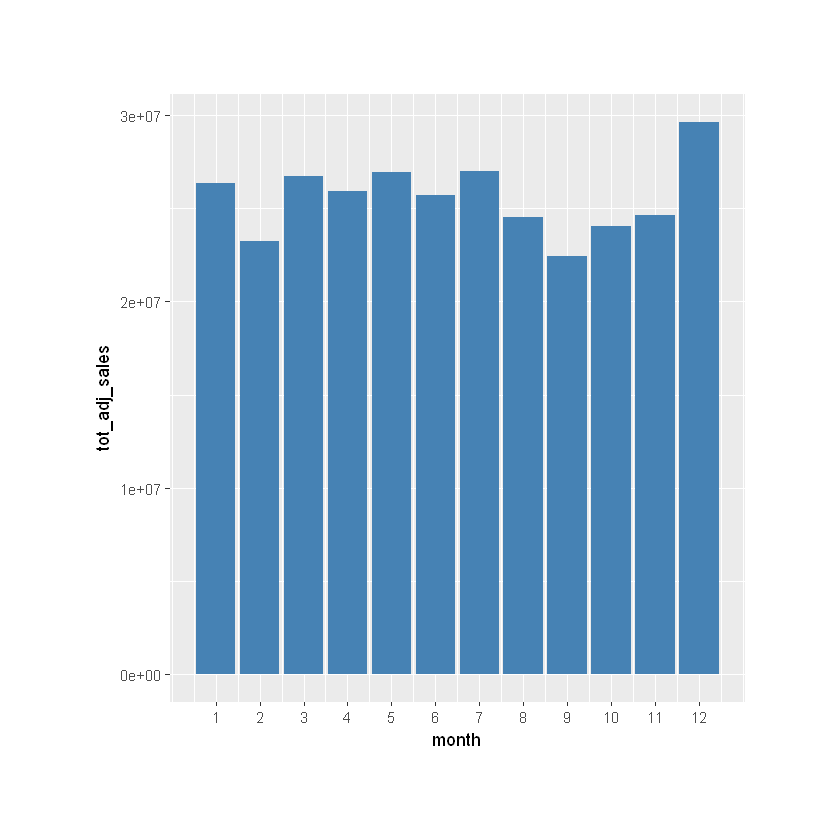

In [8]:
ggplot(train_n_month, aes(month, tot_adj_sales)) + geom_bar(stat="identity", fill="steelblue") +
        scale_x_continuous(breaks=1:12) + theme(plot.margin = unit(c(2, 2, 2, 2), "cm"))

Average sales and total sales are highest on the first 5 days of the month and lowest towards the end of the month. 


This might be related to when people are getting paid (we know that public workers in Ecuador are paid on the 15th and the end of the month).


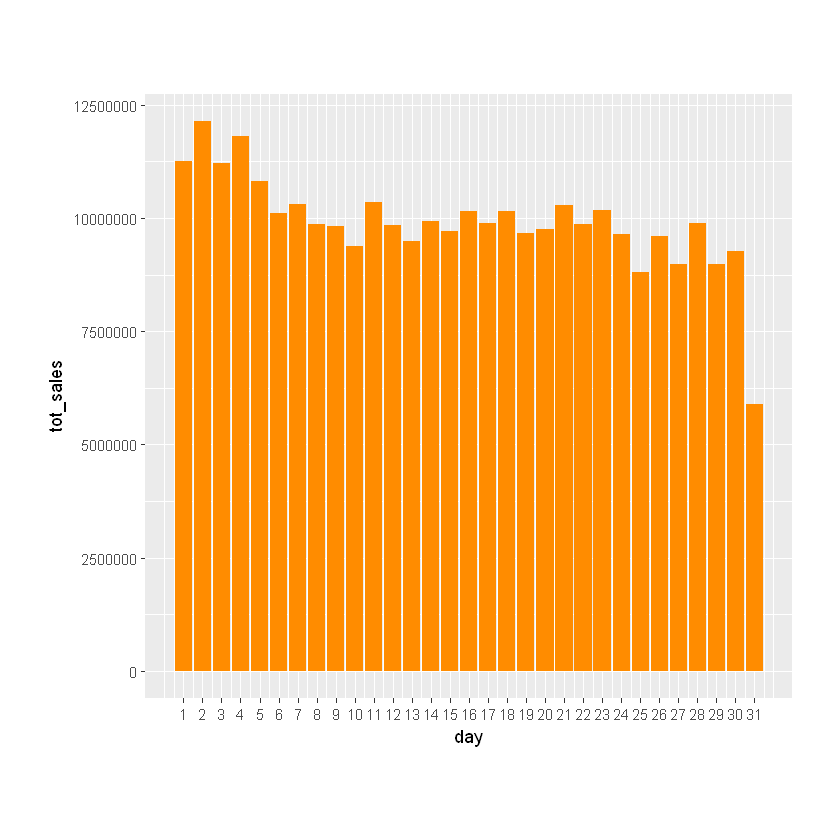

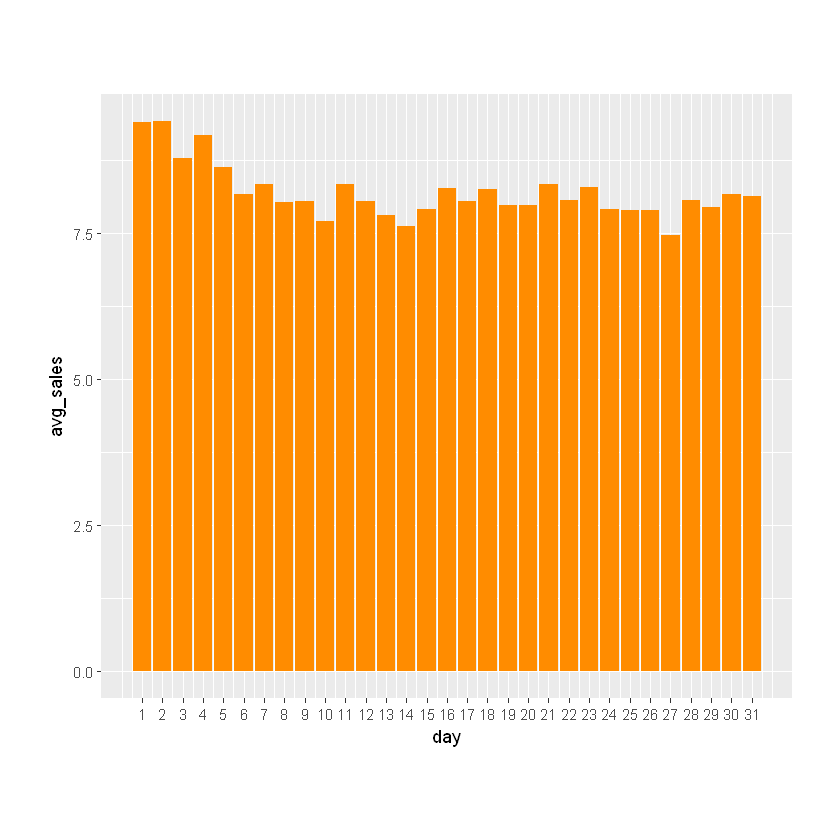

In [9]:
# total sales by day is not a good comparison measure since days by month are different but the graph still allows us to see the magnitude of sales
ggplot(train_n_day, aes(day, tot_sales)) + geom_bar(stat="identity", fill="dark orange") + scale_x_continuous(breaks=1:31) + 
        theme(plot.margin = unit(c(2, 1, 2, 1), "cm"))
ggplot(train_n_day, aes(day, avg_sales)) + geom_bar(stat="identity", fill = "dark orange") + scale_x_continuous(breaks=1:31) + 
        theme(plot.margin = unit(c(2, 1, 2, 1), "cm"))


Below we plot the total sales time series. We can see the jump in December and also that on Jan.1 the stores are closed.

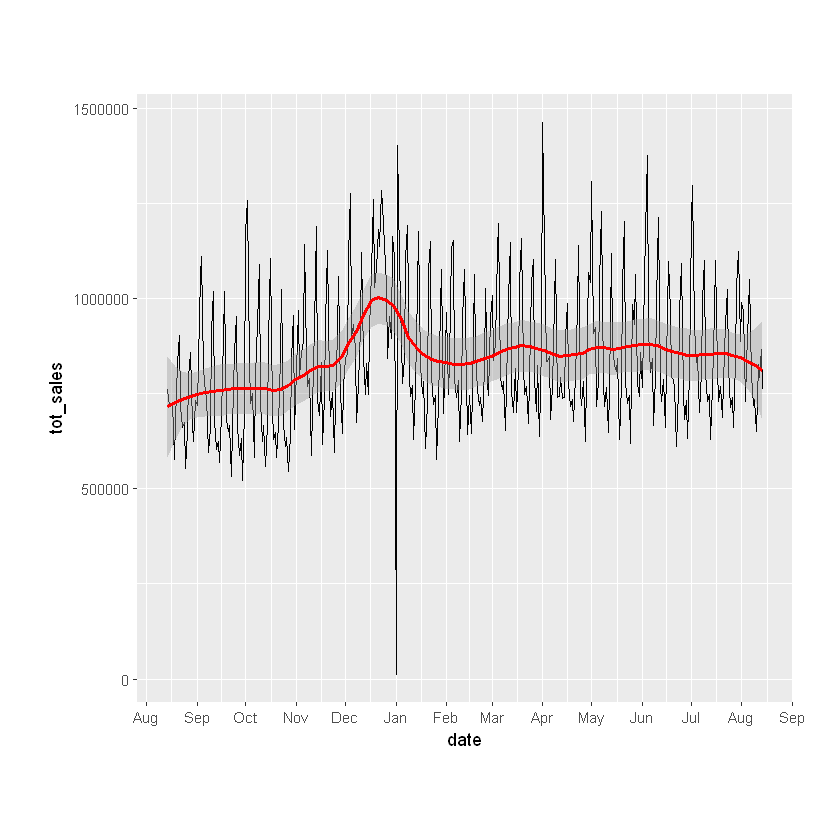

In [10]:
ggplot(train_n_ts, aes(date, tot_sales)) + geom_line() + scale_x_date(date_breaks="months", date_labels="%b") +
        geom_smooth(method = "loess", color = "red", span = 1/5) + theme(plot.margin = unit(c(2, 1, 2, 1), "cm"))


### Load additional files

### holidays_events file


In [11]:
holidays_events = read.csv("holidays_events.csv", stringsAsFactors = FALSE)
holidays_events$date = as.Date(holidays_events$date)

summary(holidays_events)

      date                type              locale          locale_name       
 Min.   :2012-03-02   Length:350         Length:350         Length:350        
 1st Qu.:2013-12-23   Class :character   Class :character   Class :character  
 Median :2015-06-08   Mode  :character   Mode  :character   Mode  :character  
 Mean   :2015-04-24                                                           
 3rd Qu.:2016-07-03                                                           
 Max.   :2017-12-26                                                           
 description        transferred       
 Length:350         Length:350        
 Class :character   Class :character  
 Mode  :character   Mode  :character  
                                      
                                      
                                      

In [12]:
unique(holidays_events$transferred)

[1] "False" "True"

The "transferred" column is important since it shows whether this holiday has been transferred, in which case it should not be considered as a holiday.

We only keep the holidays that are not tranferred and bring the relevant information to the training file.


In [13]:
holidays_events_actual = holidays_events[holidays_events$transferred == "False",]

train_n_ts$holiday = holidays_events_actual$type[match(train_n_ts$date, holidays_events_actual$date)]
train_n_ts$holiday = ifelse(is.na(train_n_ts$holiday), FALSE, TRUE)

Total sales tend to be higher on holidays as expected.


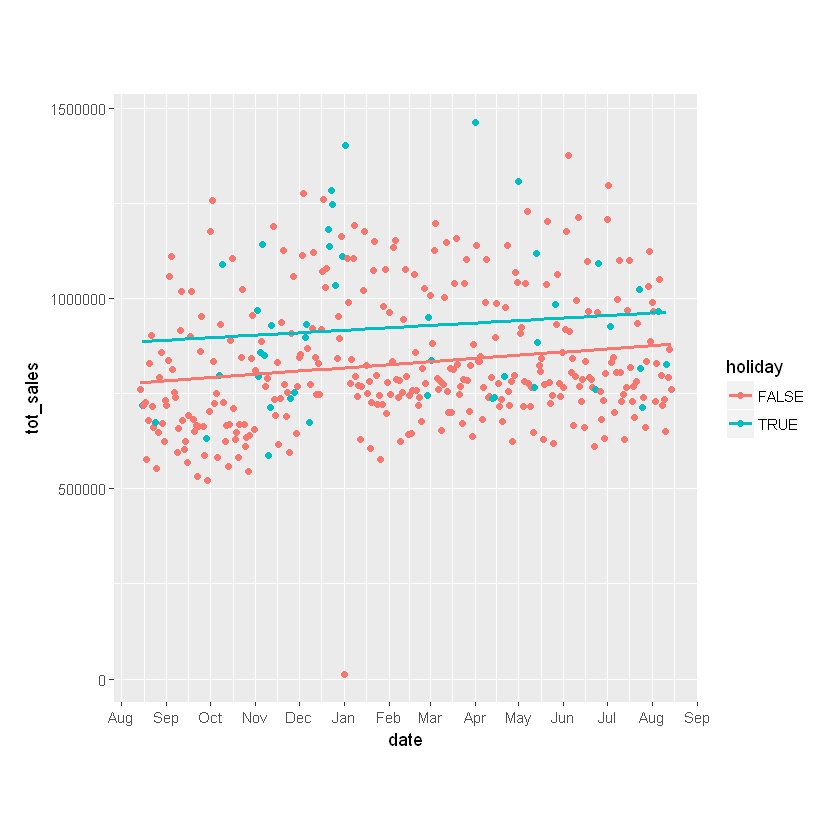

In [14]:
ggplot(train_n_ts, aes(x=date, y=tot_sales, color=holiday)) + geom_point() + 
        scale_x_date(date_breaks="months", date_labels="%b") + geom_smooth(method = "lm", se=FALSE) +
        theme(plot.margin = unit(c(2, 0.5, 2, 0.5), "cm"))


### items file

In [26]:
items = read.csv("items.csv", stringsAsFactors = FALSE)
summary(items)

train_n_flt$family = items$family[match(train_n_flt$item_nbr, items$item_nbr)]
train_n_flt$class = items$class[match(train_n_flt$item_nbr, items$item_nbr)]
train_n_flt$perishable = as.factor(items$perishable[match(train_n_flt$item_nbr, items$item_nbr)])

# Check for duplicates - no duplicates
length(unique(train_n_flt$item_nbr))
train_n_flt$item_nbr_family = paste(train_n_flt$item_nbr, train_n_flt$family)
length(unique(train_n_flt$item_nbr_family))

train_n_fam = train_n_flt %>% group_by(family) %>% summarize(tot_sales = sum(unit_sales),
                                                             tot_adj_sales = sum(adj_sales))


    item_nbr          family              class        perishable    
 Min.   :  96995   Length:4100        Min.   :1002   Min.   :0.0000  
 1st Qu.: 818111   Class :character   1st Qu.:1068   1st Qu.:0.0000  
 Median :1306198   Mode  :character   Median :2004   Median :0.0000  
 Mean   :1251436                      Mean   :2170   Mean   :0.2405  
 3rd Qu.:1904918                      3rd Qu.:2990   3rd Qu.:0.0000  
 Max.   :2134244                      Max.   :7780   Max.   :1.0000  

[1] 4036

[1] 4036

Gorcery I, beverages, produce, cleaning and dairy are the top 5 categories sold.

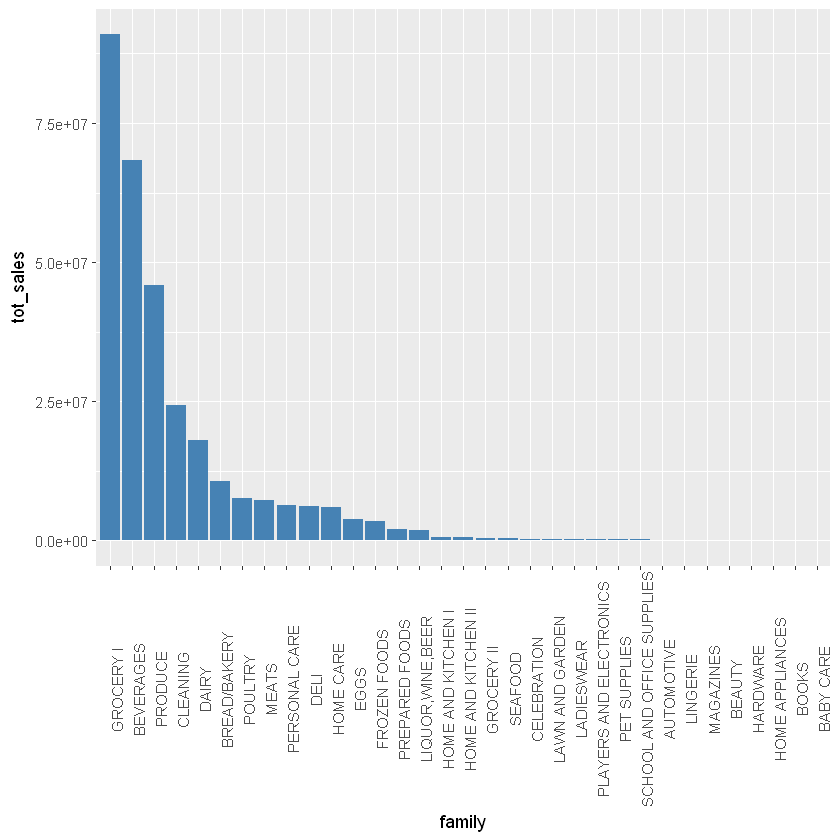

In [27]:
train_n_fam_ord = train_n_fam[order(train_n_fam$tot_sales, decreasing = TRUE), ]  
train_n_fam_ord$family = factor(train_n_fam_ord$family, levels = train_n_fam_ord$family) 
ggplot(train_n_fam_ord, aes(family, tot_sales)) + geom_bar(stat="identity", fill="steelblue") + 
        theme(axis.text.x=element_text(angle=90))


### oil file

In [29]:
oil = read.csv("oil.csv", stringsAsFactors = FALSE)
oil$date = as.Date(oil$date)

#oil$month = as.numeric(format(oil$date, "%m"))
#oil_month = oil %>% group_by(month) %>% summarize(avg_price = mean(price))

summary(oil)

      date              dcoilwtico    
 Min.   :2013-01-01   Min.   : 26.19  
 1st Qu.:2014-03-03   1st Qu.: 46.41  
 Median :2015-05-02   Median : 53.19  
 Mean   :2015-05-02   Mean   : 67.71  
 3rd Qu.:2016-06-30   3rd Qu.: 95.66  
 Max.   :2017-08-31   Max.   :110.62  
                      NA's   :43      

We fill in the missing values using linear interpolation of the elements before and after. The very first value of the time series is also missing so we make it equal to the second value.


In [30]:
oil[1,2] = oil[2,2]
oil$price = na.approx(oil$dcoilwtico)

summary(oil)

      date              dcoilwtico         price       
 Min.   :2013-01-01   Min.   : 26.19   Min.   : 26.19  
 1st Qu.:2014-03-03   1st Qu.: 46.41   1st Qu.: 46.42  
 Median :2015-05-02   Median : 53.19   Median : 53.19  
 Mean   :2015-05-02   Mean   : 67.74   Mean   : 67.68  
 3rd Qu.:2016-06-30   3rd Qu.: 95.64   3rd Qu.: 95.69  
 Max.   :2017-08-31   Max.   :110.62   Max.   :110.62  
                      NA's   :42                       

In [37]:
oil$month = as.numeric(format(oil$date, "%m"))
train_n_ts$oil_price = oil$price[match(train_n_ts$date, oil$date)]

oil_flt = oil %>% filter(date >= "2016-08-14" & date <= "2017-08-14") 
oil_month = oil_flt %>% group_by(month) %>% summarize(avg_price = mean(price))

Total sales and oil price do not seem to be correlated:

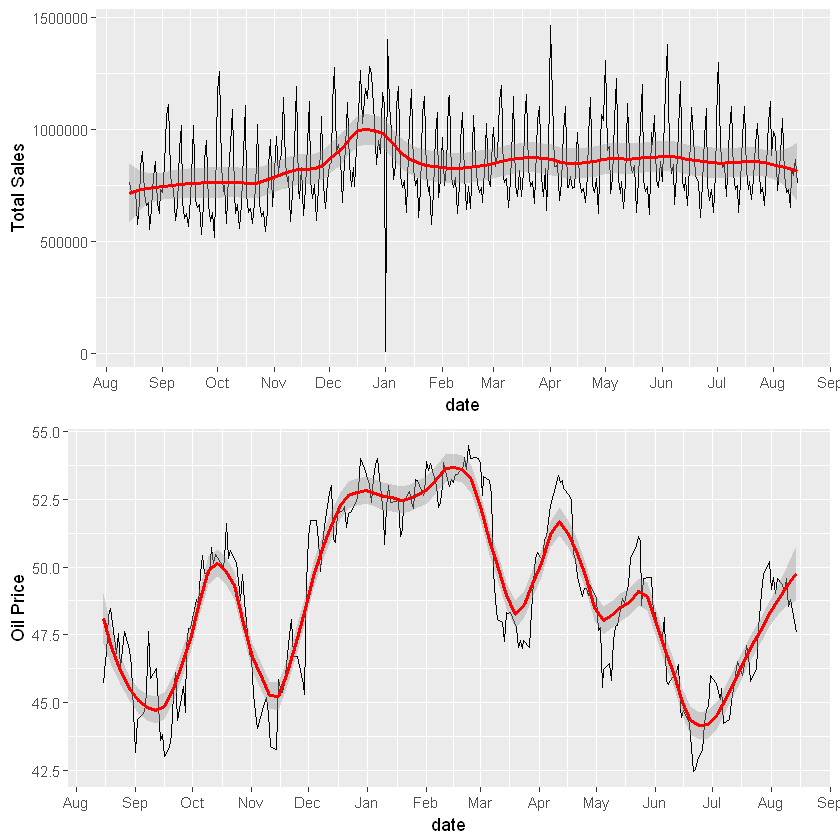

In [77]:
plot1 = ggplot(train_n_ts, aes(date, tot_sales)) + geom_line() + geom_smooth(method = "loess", color = "red", span = 1/5) + 
            scale_x_date(date_breaks="months", date_labels="%b") + labs(y="Total Sales")
plot2 = ggplot(oil_flt, aes(date, price)) + geom_line() + geom_smooth(method = "loess", color = "red", span = 1/5) + 
            scale_x_date(date_breaks="months", date_labels="%b") + labs(y="Oil Price")
grid.arrange(plot1, plot2, nrow=2)

### stores file

In [40]:
stores = read.csv("stores.csv", stringsAsFactors = FALSE)

summary(stores)

   store_nbr         city              state               type          
 Min.   : 1.00   Length:54          Length:54          Length:54         
 1st Qu.:14.25   Class :character   Class :character   Class :character  
 Median :27.50   Mode  :character   Mode  :character   Mode  :character  
 Mean   :27.50                                                           
 3rd Qu.:40.75                                                           
 Max.   :54.00                                                           
    cluster      
 Min.   : 1.000  
 1st Qu.: 4.000  
 Median : 8.500  
 Mean   : 8.481  
 3rd Qu.:13.000  
 Max.   :17.000  

Sales are highest for cluster 14 and lowest for cluster 16.

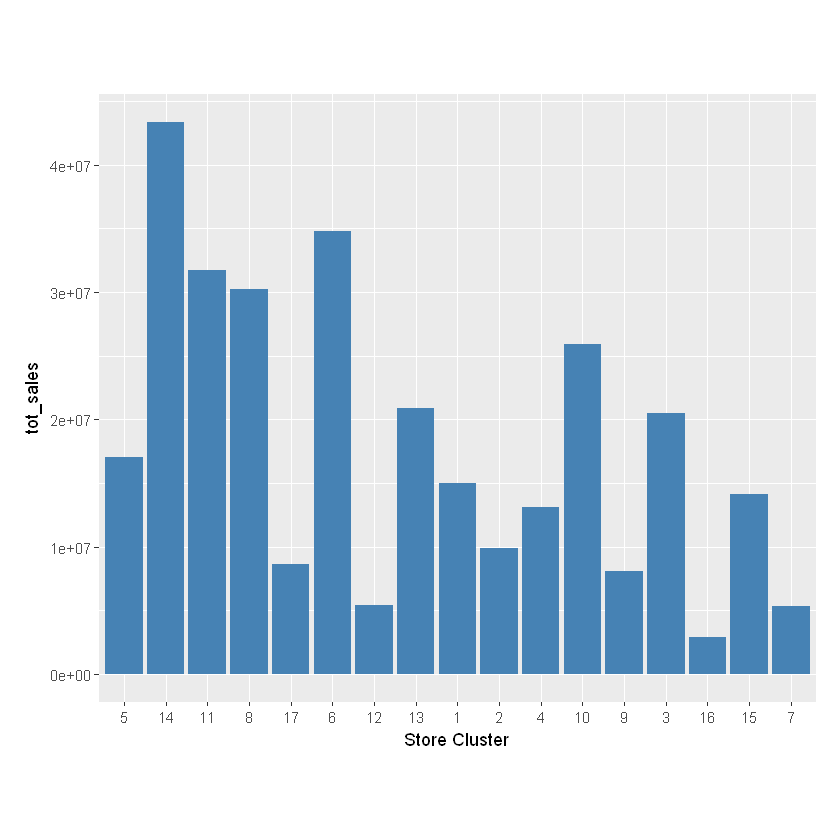

In [44]:
train_n_store$store_cluster = stores$cluster[match(train_n_store$store_nbr, stores$store_nbr)]
train_n_store_month$store_cluster = stores$cluster[match(train_n_store_month$store_nbr, stores$store_nbr)]

ggplot(train_n_store, aes(x=reorder(store_cluster, -tot_sales), y=tot_sales)) + geom_bar(stat="identity", fill="steelblue") + 
        theme(plot.margin = unit(c(2, 0.5, 2, 0.5), "cm")) + labs(x="Store Cluster")


In the following map we show the total number of stores by location:

In [58]:
# latitide and longitute of Ecuador cities in the dataset

lat =  c(-1.24,  -1.8, 0.05, -2.9, -1.86, -1.32, 0.95, -1.61, -2.21, 0.36, -0.93, -2.23, -3.99, -3.26, -0.96, -2.63, -1.48, -1.02,
         -0.19, -1.67, -2.2, -0.25) 

lng = c(-78.62, -79.54, -78.16, -79.01, -79.98, -80.02, -79.67, -79.01, -79.9, -78.13, -78.61, -80.9, -79.21, -79.96, -80.72, -80.39,
        -77.99, -79.48, -78.5, -78.65, -80.98, -79.16)

stores_by_city = stores %>% group_by(city) %>% summarize(num_stores = n())


In [68]:
ecuador_center = as.numeric(geocode("Ecuador"))

EcuadorMap = ggmap(get_googlemap(center=ecuador_center, zoom=6), extent="normal")


Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Ecuador&sensor=false
Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=-1.831239,-78.183406&zoom=6&size=640x640&scale=2&maptype=terrain&sensor=false


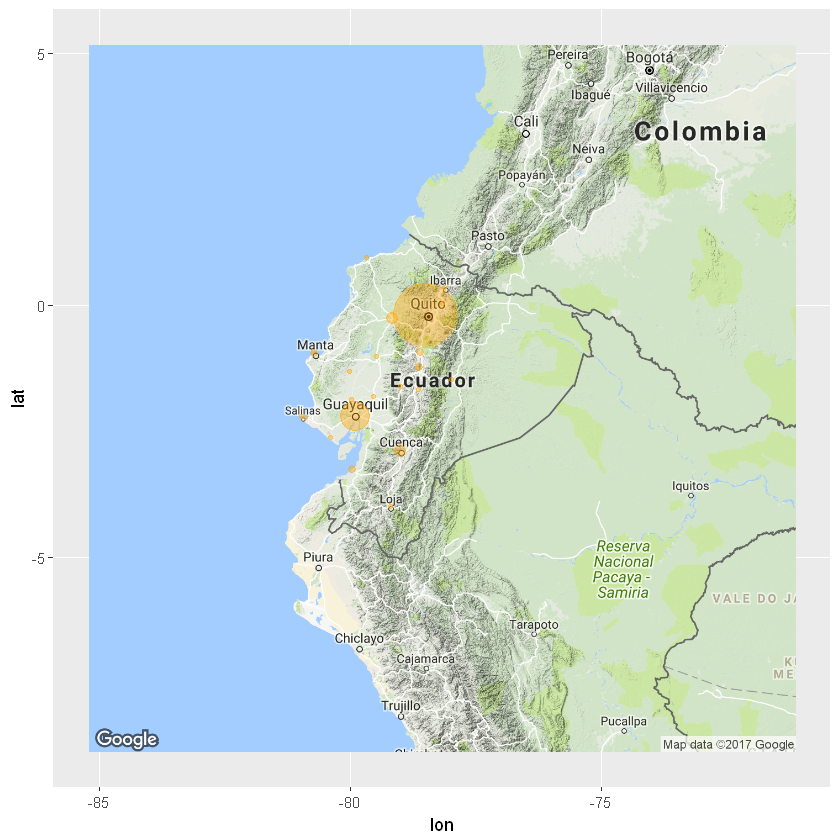

In [69]:
EcuadorMap + geom_point(aes(x=lng, y=lat), data=stores_by_city, col="orange", alpha=0.4, size=stores_by_city$num_stores) +
                    scale_size_continuous(range=range(stores_by_city$num_stores))


According to the 2010 census, Guayaquil is the largest city in Ecuador (2.3 million), followed by Quito (1.6 million) and then by Cuenca (330,000) (Source: Wikipedia).

The grocery chain has most of its stores in Quito which means there should another player in Guayaquil.

### transactions file

In [70]:
transactions = read.csv("transactions.csv", stringsAsFactors = FALSE)
transactions$date = as.Date(transactions$date)

summary(transactions)


      date              store_nbr      transactions 
 Min.   :2013-01-01   Min.   : 1.00   Min.   :   5  
 1st Qu.:2014-03-27   1st Qu.:13.00   1st Qu.:1046  
 Median :2015-06-08   Median :27.00   Median :1393  
 Mean   :2015-05-20   Mean   :26.94   Mean   :1695  
 3rd Qu.:2016-07-14   3rd Qu.:40.00   3rd Qu.:2079  
 Max.   :2017-08-15   Max.   :54.00   Max.   :8359  

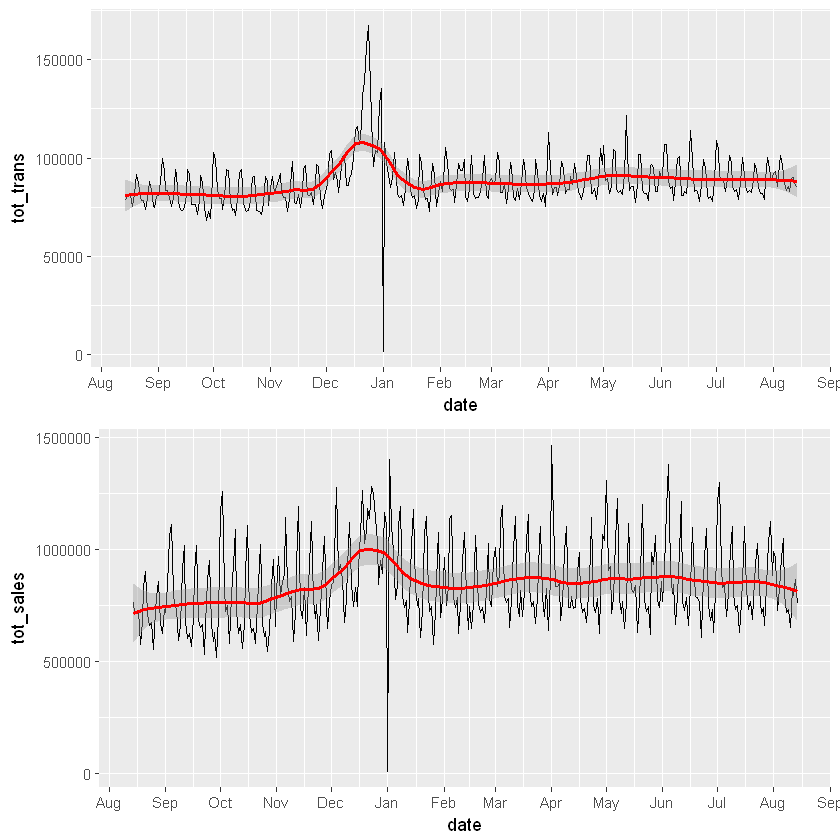

In [76]:
plot1 = transactions %>% filter(date >= "2016-08-14" & date <= "2017-08-14") %>% group_by(date) %>% 
    summarize(tot_trans = sum(transactions)) %>% ggplot(aes(date, tot_trans)) + geom_line() +
    scale_x_date(date_breaks="months", date_labels="%b") + geom_smooth(method = "loess", color = "red", span = 1/5)
plot2 = ggplot(train_n_ts, aes(date, tot_sales)) + geom_line() + scale_x_date(date_breaks="months", date_labels="%b") +
        geom_smooth(method = "loess", color = "red", span = 1/5)
grid.arrange(plot1, plot2, nrow=2)

We plot both total transactions and total sales for comparison. In both cases we can see the peak in December. 

For some of the peaks, for example the one in April, it seems that total sales grow proportionally more than total transactions, which means that we have more items per transaction. Actually, on April 16, 2016, Ecuador experienced a 7.6 magnitude earthquake. So it makes sense that items were bought in bulk in order to help with relief efforts.

As part of the next steps of this analysis we will also calculate the sales/transaction and see how this moves over time.

### Key Takeaways

This analysis is still work in progress. It is the first attempt of a high-level exploratory analysis of the datasets provided for the "Corporacion Favorita" sales prediction competition. 

The files were read in and summarized and we can note the following:
   * Due to the large size of the training dataset only the most recent year of data was analyzed.
   * Total sales across the year indicate seasonality, highest in December and lowest in September.
   * Total sales are also higher at the beginning of the month as opposed to the end.
   * Total sales tend to be higher on holidays as well as for items that are on promotion.
   * The items that sell the most are groceries (grocery I), beverages and produce.
   * Oil price does not seem to affect sales (at least not in the short term).
   * Stores are placed in different clusters and these clusters have different total sales between them.
   * Most stores are located in Quito, which is the second largest city, followed by Quayaquil.
   * Transacations are also moving with sales but additional analysis is needed to look at the sales/transaction across time.
   
More work will be done on this analysis in order to capture all the information provided through the datasets before moving on to the sales prediction part.